# Predicting regional diagnosed percentage and positivity

In this example, we estimate chlamydia prevalence in each sex separately. Then, using the observed prevalence-incidence relationship we predict incidence in each sex from prevalence in the other. Finally, we introduce the percentage tested to predict the percentage diagnosed - a quantity which can be compared to observation to validate the method.

In [2]:
n_sample = 10000

In [19]:
# read in the regional (upper-tier local authority) testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv('../../2012_age_sex_region.csv')

# remove areas missing data because of small numbers
data = data[data['positives.male.20-24'] != 0]
data = data.reset_index(drop=True)

data

,laut,gor,phec,pher,tests.male.15-19,tests.male.20-24,tests.male.total,tests.female.15-19,tests.female.20-24,tests.female.total,...,positives.female.20-24,positives.female.total,positives.total.15-19,positives.total.20-24,positives.total,population.male.15-19,population.male.20-24,population.female.15-19,population.female.20-24,population.total
0,Barking and Dagenham,london,London,London,1741,1466,3207,2354,2811,5165,...,174,407,317,284,601,6672,6484,6137,6532,25825
1,Barnet,london,London,London,491,1514,2005,1568,3591,5159,...,232,380,194,370,564,10694,11651,9883,11938,44166
2,Bexley,london,London,London,631,990,1621,1355,1795,3150,...,121,255,189,201,390,7850,7582,7705,7709,30846
3,Brent,london,London,London,1209,2818,4027,2478,5259,7737,...,331,565,333,560,893,9809,11764,8587,11081,41241
4,Bromley,london,London,London,1049,1278,2327,1935,2573,4508,...,139,277,199,249,448,9289,7845,8810,8460,34404
5,Camden,london,London,London,1225,2310,3535,3182,6368,9550,...,341,585,358,525,883,5915,10708,5777,12163,34563
6,City of London,london,London,London,12,25,37,12,88,100,...,5,7,2,7,9,113,232,118,263,726
7,Croydon,london,London,London,1570,2360,3930,3442,4996,8438,...,392,809,563,679,1242,12161,11330,11377,11696,46564
8,Ealing,london,London,London,1126,1811,2937,1842,3359,5201,...,204,333,177,346,523,9660,11740,8980,11077,41457
9,Enfield,london,London,London,609,1353,1962,1852,3732,5584,...,193,329,180,273,453,10808,10346,9714,10974,41842


In [20]:
from numpy import *
from scipy.stats import beta
from scipy.stats import gamma
from numpy.random import normal

n_sample = 10000
n_la = len(data.index)

# sexually-active population:
p_active_m = random.beta(1307.6511 + 1, 1630.126 - 1307.6511 + 1, size=(n_sample,n_la))
p_active_f = random.beta(1255.6630 + 1, 1534.735 - 1255.6630 + 1, size=(n_sample,n_la))

pop_active_m = zeros([n_sample,len(data.index)])
pop_active_f = zeros([n_sample,len(data.index)])
diag_rate_m = zeros([n_sample,len(data.index)])
test_rate_m = zeros([n_sample,len(data.index)])
diag_rate_f = zeros([n_sample,len(data.index)])
test_rate_f = zeros([n_sample,len(data.index)])

for i in xrange(len(data.index)):
    pop_active_m[:,i] = random.binomial(data['population.male.20-24'][i], p_active_m[:,i])
    pop_active_f[:,i] = random.binomial(data['population.female.20-24'][i], p_active_f[:,i])

    # data in men: testing and diagnosis rates, per person per year
    diag_rate_m[:,i] = random.gamma(data['positives.male.20-24'][i], size=n_sample)/pop_active_m[:,i]
    test_rate_m[:,i] = random.gamma(data['tests.male.20-24'][i], size=n_sample)/pop_active_m[:,i]
    diag_rate_f[:,i] = random.gamma(data['positives.female.20-24'][i], size=n_sample)/pop_active_f[:,i]
    test_rate_f[:,i] = random.gamma(data['tests.female.20-24'][i], size=n_sample)/pop_active_f[:,i]

# proportion of incident infections asymptomatic is not known, and 
# proportion of prevalent infections asymptomatic would depend on the screening programme.
# for the moment, assume
p_asymp_m = random.beta(69 + 1, 78 - 69 + 1, size=(n_sample,n_la)) # Mackay et al. Lancet 361 (2003) NB this is an upper bound, as relates to the proportion of prevalent - not incident - infections
p_asymp_f = random.beta(163 + 1, 185 - 163 + 1, size=(n_sample,n_la)) # Kahn et al. STDs (2003) NB this is an upper bound, as relates to the proportion of prevalent - not incident - infections. It's also from the US, and the % reported in the paper doesn't give a whole number of patients..

# test performance
p_true_pos_m = random.beta(32+1, 0+1, size=(n_sample,n_la)) # Horner J. Clin. Microbiol (2005): 32 of 32 infected samples tested +ve
p_false_pos_m = random.beta(2+1, 950+1, size=(n_sample,n_la)) # Horner J. Clin. Microbiol (2005): 2 of 952 uninfected samples tested +ve
p_true_pos_f = random.beta(129+1, 12+1, size=(n_sample,n_la)) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = random.beta(4+1, 2323+1, size=(n_sample,n_la)) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve 

In [21]:
# run a script which does some sampling for other parameters (see example.ipynb for more detail)
%run multinomial_pmf.py
%run -i contrasting_regions_2012_prior_sampler.py

In [22]:
# now use these samples to try and infer prevalence in men and women
# this script contains the functions for three-part observations (tests, symptomatic diagnoses, asymptomatic diagnoses) too
# running this script takes a little while because of all the symbolic algebra
%run test_diag_fun.py

from numpy import *
from scipy.optimize import fsolve

In [23]:
# men first...
prev_m_laut = zeros([n_sample,len(data.index)])
inc_m_laut = zeros([n_sample,len(data.index)])
scr_m_laut = zeros([n_sample,len(data.index)])

for j in xrange(len(data.index)):
    # keep track of whether stuff is happening
    if fmod(j,10)==0:
        print j, data.laut[j]

    for i in xrange(n_sample):
        [inc_m_laut[i,j], scr_m_laut[i,j]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_m[i,j], # proportion of incident infections which are symptomatic
                                sc_m[i,j], # rate of self-clear 
                                att_symp[i,j],
                                p_true_pos_m[i,j], 
                                p_false_pos_m[i,j]
                            ])])) - array([test_rate_m[i,j],diag_rate_m[i,j]]), [0.09, 0.25])
        prev_m_laut[i,j] = dyn_fun(inc_m_laut[i,j]*p_asymp_m[i,j], sc_m[i,j] + scr_m_laut[i,j]*p_true_pos_m[i,j], inc_m_laut[i,j]*(1-p_asymp_m[i,j]), sc_m[i,j] + att_symp[i,j]*p_true_pos_m[i,j])


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


In [24]:
# ...then women
prev_f_laut = zeros([n_sample,len(data.index)])
inc_f_laut = zeros([n_sample,len(data.index)])
scr_f_laut = zeros([n_sample,len(data.index)])

for j in xrange(len(data.index)):
    # keep track of whether stuff is happening
    if fmod(j,10)==0:
        print j, data.laut[j]

    for i in xrange(n_sample):
        [inc_f_laut[i,j], scr_f_laut[i,j]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[i,j], # proportion of incident infections which are symptomatic
                                sc_f[i,j], # rate of self-clear 
                                att_symp[i,j],
                                p_true_pos_f[i,j], 
                                p_false_pos_f[i,j]
                            ])])) - array([test_rate_f[i,j],diag_rate_f[i,j]]), [0.09, 0.25])
        prev_f_laut[i,j] = dyn_fun(inc_f_laut[i,j]*p_asymp_f[i,j], sc_f[i,j] + scr_f_laut[i,j]*p_true_pos_f[i,j], inc_f_laut[i,j]*(1-p_asymp_f[i,j]), sc_f[i,j] + att_symp[i,j]*p_true_pos_f[i,j])


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


[ 0.96189195  0.0282608 ]
[ 2.01182888 -0.01337911]


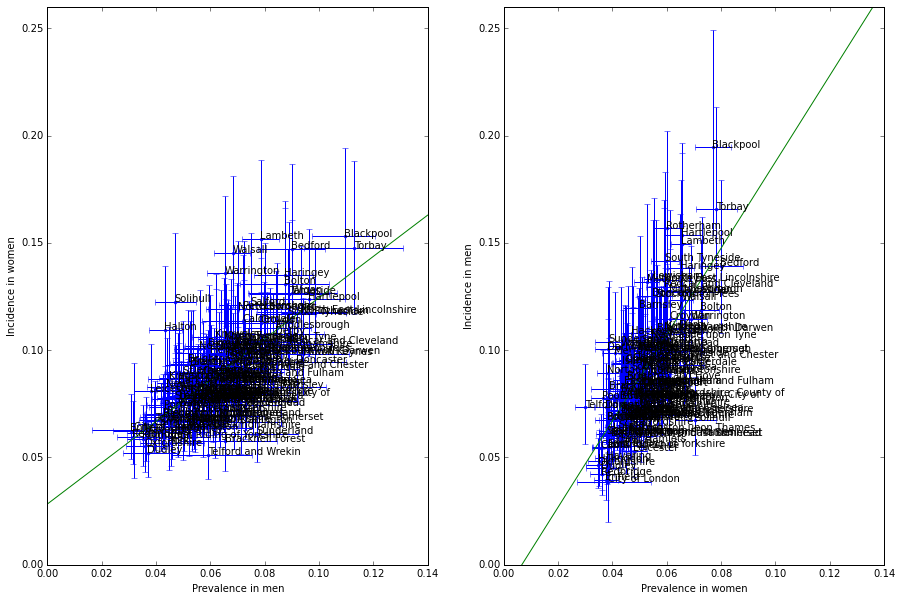

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#for i in xrange(len(data.index)):

x = percentile(prev_m_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(prev_m_laut,[25, 75],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[25, 75],axis=0) - y)
ax1.errorbar(array(x), array(y), xerr=xerr, yerr=yerr, fmt='.')
for i in xrange(n_la):
    ax1.text(x[i], y[i], data.laut[i])

mf_fit = np.polyfit(x, y, 1)
p = poly1d(mf_fit)
print mf_fit
ax1.plot([0,0.14], p([0,0.14]), '-')

x = percentile(prev_f_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(prev_f_laut,[25, 75],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[25, 75],axis=0) - y)
ax2.errorbar(array(x), array(y), xerr=xerr, yerr=yerr, fmt='.')
for i in xrange(n_la):
    ax2.text(x[i], y[i], data.laut[i])

fm_fit = np.polyfit(x, y, 1)
p = poly1d(fm_fit)
print fm_fit
ax2.plot([0,0.14], p([0,0.14]), '-')

ax1.set_xlim(0,0.14); ax2.set_xlim(0,0.14)
ax1.set_xlabel('Prevalence in men'); ax2.set_xlabel('Prevalence in women')
ax1.set_ylim(0,0.26); ax2.set_ylim(0,0.26)
ax1.set_ylabel('Incidence in women'); ax2.set_ylabel('Incidence in men')

[ 0.56998673  0.01231488]
[ 0.42490305  0.01291127]


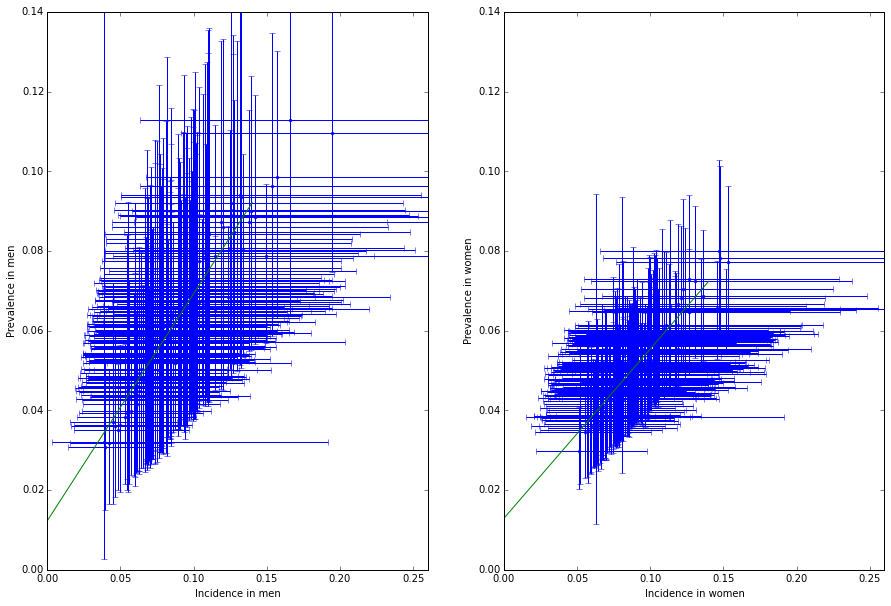

In [39]:

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#for i in xrange(len(data.index)):

x = percentile(inc_m_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
xerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(array(x), array(y), xerr=xerr, yerr=yerr, fmt='.')
# for i in xrange(n_la):
#     ax1.text(x[i], y[i], data.laut[i])

mf_fit = np.polyfit(x, y, 1)
p = poly1d(mf_fit)
print mf_fit
ax1.plot([0,0.14], p([0,0.14]), '-')

x = percentile(inc_f_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
xerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(array(x), array(y), xerr=xerr, yerr=yerr, fmt='.')
# for i in xrange(n_la):
#     ax2.text(x[i], y[i], data.laut[i])

fm_fit = np.polyfit(x, y, 1)
p = poly1d(fm_fit)
print fm_fit
ax2.plot([0,0.14], p([0,0.14]), '-')

ax1.set_xlim(0,0.26); ax2.set_xlim(0,0.26)
ax1.set_xlabel('Incidence in men'); ax2.set_xlabel('Incidence in women')
ax1.set_ylim(0,0.14); ax2.set_ylim(0,0.14)
ax1.set_ylabel('Prevalence in men'); ax2.set_ylabel('Prevalence in women')

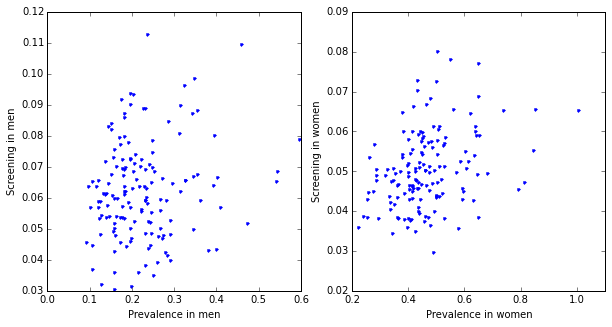

In [33]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#for i in xrange(len(data.index)):

x = percentile(scr_m_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
ax1.plot(array(x), array(y), '.b')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
ax2.plot(array(x), array(y), '.b')

#ax1.set_xlim(0,0.09); ax2.set_xlim(0,0.09)
ax1.set_xlabel('Prevalence in men'); ax2.set_xlabel('Prevalence in women')
#ax1.set_ylim(0,0.16); ax2.set_ylim(0,0.16)
ax1.set_ylabel('Screening in men'); ax2.set_ylabel('Screening in women')


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Torbay
140 Kent
150 Windsor and Maidenhead


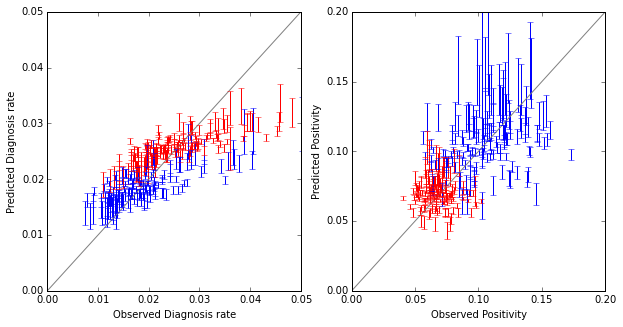

In [9]:
# for each region, would like to infer the diagnosis rate and positivity 
# assuming uniform incidence and given testing rate (all in 20-24-year-olds)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot([0,1], [0,1], '0.5')
ax2.plot([0,1], [0,1], '0.5')

def plt_ppc(ax, xsample, ysample, ci, col): # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50), 
                percentile(ysample, 50), 
                yerr=array([[percentile(ysample,50) - percentile(ysample, (100.-ci)/2)], [percentile(ysample, (100.+ci)/2) - percentile(ysample,50)]]), 
                #xerr=array([[percentile(xsample,50) - percentile(xsample, (100.-ci)/2)], [percentile(xsample, (100.+ci)/2) - percentile(xsample,50)]]),
                ecolor=col
                )

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.laut[i]
    
    #####
    # men
    #####
    # sample for the testing rate
    test_sample = p_active_m = random.beta(
        alldata['tests.male.20-24'][i]+1, 
        alldata['population.male.20-24'][i] - alldata['tests.male.20-24'][i] + 1, 
        size=n_sample)
    diag_sample = p_active_m = random.beta(
        alldata['positives.male.20-24'][i]+1, 
        alldata['population.male.20-24'][i] - alldata['positives.male.20-24'][i] + 1, 
        size=n_sample)

    # screening and diagnosis rates
    scr_m_laut = zeros(n_sample)
    diag_m_laut = zeros(n_sample)
    for j in xrange(n_sample):
        [scr_m_laut[j], diag_m_laut[j]] = fsolve(lambda x: test_diag_fun(concatenate([
                    array([inc_m[j], x[0]]), array([
                        1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                        sc_m[j], # rate of self-clear 
                        att_symp[j],
                        p_true_pos_m[j], 
                        p_false_pos_m[j]
                        ])])) - array([test_sample[j], x[1]]), [0.3, 0.3])

    # positivity
    pos_m_laut = diag_m_laut/test_sample
    
    # add to plot
    plt_ppc(ax1, diag_sample, diag_m_laut, 95, 'b')
    plt_ppc(ax2, diag_sample/test_sample, diag_m_laut/test_sample, 95, 'b')
    
    #####
    # women
    #####
    # sample for the testing rate
    test_sample = p_active_m = random.beta(
        alldata['tests.female.20-24'][i]+1, 
        alldata['population.female.20-24'][i] - alldata['tests.female.20-24'][i] + 1, 
        size=n_sample)
    diag_sample = p_active_f = random.beta(
        alldata['positives.female.20-24'][i]+1, 
        alldata['population.female.20-24'][i] - alldata['positives.female.20-24'][i] + 1, 
        size=n_sample)

    # screening and diagnosis rates
    scr_f_laut = zeros(n_sample)
    diag_f_laut = zeros(n_sample)
    for j in xrange(n_sample):
        [scr_f_laut[j], diag_f_laut[j]] = fsolve(lambda x: test_diag_fun(concatenate([
                    array([inc_f[j], x[0]]), array([
                        1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                        sc_f[j], # rate of self-clear 
                        att_symp[j],
                        p_true_pos_f[j], 
                        p_false_pos_f[j]
                        ])])) - array([test_sample[j], x[1]]), [0.3, 0.3])

    # positivity
    pos_f_laut = diag_f_laut/test_sample
    
    # add to plot
    plt_ppc(ax1, diag_sample, diag_f_laut, 95, 'r')
    plt_ppc(ax2, diag_sample/test_sample, diag_f_laut/test_sample, 95, 'r')

ax1.set_xlim([0,0.05]); ax1.set_ylim([0,0.05])
ax1.set_xlabel('Observed Diagnosis rate')
ax1.set_ylabel('Predicted Diagnosis rate')
ax2.set_xlim([0,0.2]); ax2.set_ylim([0,0.2])
ax2.set_xlabel('Observed Positivity')
ax2.set_ylabel('Predicted Positivity')

In [ ]:
plt.plot(
    alldata['tests.male.20-24'],
    alldata['tests.female.20-24'],
    '.b'
    )
    

In [ ]:
plt.plot(
    alldata['positives.male.20-24'],
    alldata['positives.female.20-24'],
    '.b'
    )